# Lane Detection Project

In this project you need to construct computer vision solution for a lane detection. We are going to implement [LaneNet](https://arxiv.org/pdf/1802.05591.pdf) paper. Our solution is going to have the following parts:

1. Lane semantic segmentation and metric learning
2. Instance segmentation over embedings
3. Homography prediction
4. Lane fitting

We are going to use [TuSimple](https://github.com/TuSimple/tusimple-benchmark/issues/3) dataset for a lane detection.

Let's discuss every step in details.

## Semantic and Instance Segmentation

In this part you should implement and train neural network with the 2 heads. The model should take as an input image and returns to masks. One head should predict *semantic segmentation* and another head should predict *embedding for each pixel*. Pixels that are part of one lane should have similar embeddings, on the other hand pixels from different lanes should have high distance between embeddings. In order to do that, we should implement *discriminative loss*.

After training the discribed network, we can threshold pixels of the interest and cluster them according to the embedding with the *DBSCAN*.

After solving the problem you should obtain the following result.

## Homograpy Prediction

In order to solve the problem, we would like to understand an exact lane geometry. We are going to describe the lane with the 2-nd order polynom $ax^2 + bx + c$.

In the image plane lines are not parallel and we may need higher order polynoms to discribe the lane geometry. In order to avoid that we could project image in the bird's eye view with the homography. But drivable surface has different properties over frames, so we would like to condition the homography on the image.

In order to do that, we going to train separate network to predict the best homography for each image.

## Lane Fitting

After predicting homography and lane's clustering we will fit 2-nd order polynom for each lane to obtain the final result. Lane fitting can be formulated as a least-squares problem, where we have points $\{x_i, y_i\}_{i=1}^n$ and we would like to estimation coefficients $a, b, c$ s.t.

$$
\sum_{i = 1}^n ||y_i - a x_i^2 - bx_i - c||^2 \rightarrow \min_{a, b,c}
$$



## Important Notes
0. During the project we provide the relevant papers. Reading the papers can be very helpful (and sometimes necessary) to implement the code.
1. During the project we provide you with the code templates that you should fill.
2. Homography Prediction and Instance Segmentation can be done in parallel.
3. You are free to use any other environment instead of Google Colab.
4. You can deviate from the original papers if it helps you to solve the problem, but you should explain your solution and motivation in the text block.

## Semantic and Segmentation Code

You can use the following commands to download the dataset and unpack it. But we suggest to upload the data to the Google Drive, with Google Drive you will be able to access the data much faster.

In [ ]:
!mkdir -p /data/tusimple
!wget https://s3.us-east-2.amazonaws.com/benchmark-frontend/datasets/1/train_set.zip
!unzip train_set.zip -d /data/tusimple  #

In [2]:
!pip install kaggle
import os

os.makedirs('/home/ВАШ ПОЛЬЗОВАТЕЛЬ/.kaggle', exist_ok=True)

with open('/home/ВАШ ПОЛЬЗОВАТЕЛЬ/.kaggle/kaggle.json', 'w') as f:
    f.writelines('{"username":"zneron","key":"47c9371579baa64751f3de178eff25b2"}')
!kaggle datasets download -d manideep1108/tusimple

!mkdir data
!unzip -qq tusimple.zip -d data/tusimple

Dataset URL: https://www.kaggle.com/datasets/manideep1108/tusimple
License(s): copyright-authors
100% 21.6G/21.6G [03:26<00:00, 160MB/s]
100% 21.6G/21.6G [03:26<00:00, 112MB/s]


In the following cell you should implement pytorch Dataset to generate training examples for instance and semantic segmentation. You are able to modify the signatures if you want.

To implement the LaneDataset you should become familiar with the labeling format.

The dataset is relatively small, so it is important to implement different augmentation strategies. We suggest to use random flips and color augmentations (brightness, saturation). You can also use augmentations of your choice. Augmentations are not required to obtain a full grade but without them your model could overfit dramatically.

NOTE: It can be useful to generate binary segmentation and instance segmentation ground truth once and then use it as-is in every experiment.

In [2]:
import os
import json
import cv2
import numpy as np
import token
from torch.nn.modules import loss

In [3]:
DEFAULT_SIZE = (256, 512)
import torch


class LaneDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, train=True, size=DEFAULT_SIZE):
        self.dataset_path = dataset_path
        self.mode = 'train' if train else 'eval'
        self.image_size = size

        if self.mode == 'train':
          label_files = [os.path.join(self.dataset_path, f"label_data_{name}.json") for name in ('0313', '0531')]
        else:
          label_files = [os.path.join(self.dataset_path, f"label_data_{name}.json") for name in ('0601',)]

        self.data = []

        for label in label_files:
          self.process_label_file(label)


    def __getitem__(self, idx):
        image_path = os.path.join(self.dataset_path, self.data[idx][0])
        image = cv2.imread(image_path)
        h, w, c = image.shape
        image = cv2.resize(image, self.image_size, interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image[..., None]
        lanes = self.data[idx][1]

        segmentation_image = self.draw(h, w, lanes, 'segmentation')
        instance_image = self.draw(h, w, lanes, 'instance')

        instance_image = instance_image[..., None]

        image = torch.from_numpy(image).float().permute((2, 0, 1))
        segmentation_image = torch.from_numpy(segmentation_image.copy())
        instance_image = torch.from_numpy(instance_image.copy()).permute((2, 0, 1))
        segmentation_image = segmentation_image.to(torch.int64)

        return image, segmentation_image, instance_image # 1 x H x W [[0, 1], [2, 0]]

    def __len__(self):
        return len(self.data)

    def draw(self, h, w, lanes, image_type):
      image = np.zeros((h, w), dtype=np.uint8)
      for i, lane in enumerate(lanes):
        # color = i if image_type == 'segmentation' else i + 1
        color = 1 if image_type == 'segmentation' else i + 1
        cv2.polylines(image, [lane], False, color, 10)

      image = cv2.resize(image, self.image_size, interpolation=cv2.INTER_NEAREST)

      return image

    def process_label_file(self, file_path):
      with open(file_path) as f:
        for line in f:
          info = json.loads(line)
          image = info["raw_file"]
          lanes = info["lanes"]
          h_samples = info["h_samples"]
          lanes_coords = []

          for lane in lanes:
            x = np.array([lane]).T
            y = np.array([h_samples]).T
            xy = np.hstack((x, y))
            idx = np.where(xy[:, 0] > 0)
            lane_coords = xy[idx]
            lanes_coords.append(lane_coords)
          self.data.append((image, lanes_coords))



In [5]:
image, segmentation_image, instance_image = LaneDataset('data/tusimple/TUSimple/train_set', size=DEFAULT_SIZE)[0]

In [6]:
image.shape, segmentation_image.shape, instance_image.shape

(torch.Size([1, 512, 256]), torch.Size([512, 256]), torch.Size([1, 512, 256]))

For this task we are going to use ENet architecture. You can read the description in the [original paper](https://arxiv.org/pdf/1606.02147.pdf).

To generate two different outputs we need to have two different branches. In the LaneNet paper authers proposed to share only two first sections of the encoder between to tasks. Third section and decoder should be separate for the instance segmentation and binary segmentation problem.

The output dimension of the instance segmentation embedding should be equal to 5.

In [4]:
import torch.nn as nn
import torch


class InitialBlock(nn.Module):
    """The initial block is composed of two branches:
    1. a main branch which performs a regular convolution with stride 2;
    2. an extension branch which performs max-pooling.

    Doing both operations in parallel and concatenating their results
    allows for efficient downsampling and expansion. The main branch
    outputs 13 feature maps while the extension branch outputs 3, for a
    total of 16 feature maps after concatenation.

    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number output channels.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.

    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 bias=False,
                 relu=True):
        super().__init__()

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - As stated above the number of output channels for this
        # branch is the total minus 3, since the remaining channels come from
        # the extension branch
        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - 1,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=bias)

        # Extension branch
        self.ext_branch = nn.MaxPool2d(3, stride=2, padding=1)

        # Initialize batch normalization to be used after concatenation
        self.batch_norm = nn.BatchNorm2d(out_channels)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        # Concatenate branches
        out = torch.cat((main, ext), 1)

        # Apply batch normalization
        out = self.batch_norm(out)

        return self.out_activation(out)


class RegularBottleneck(nn.Module):
    """Regular bottlenecks are the main building block of ENet.
    Main branch:
    1. Shortcut connection.

    Extension branch:
    1. 1x1 convolution which decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. regular, dilated or asymmetric convolution;
    3. 1x1 convolution which increases the number of channels back to
    ``channels``, also called an expansion;
    4. dropout as a regularizer.

    Keyword arguments:
    - channels (int): the number of input and output channels.
    - internal_ratio (int, optional): a scale factor applied to
    ``channels`` used to compute the number of
    channels after the projection. eg. given ``channels`` equal to 128 and
    internal_ratio equal to 2 the number of channels after the projection
    is 64. Default: 4.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer described above in item 2 of the extension
    branch. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - dilation (int, optional): spacing between kernel elements for the
    convolution described in item 2 of the extension branch. Default: 1.
    asymmetric (bool, optional): flags if the convolution described in
    item 2 of the extension branch is asymmetric or not. Default: False.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.

    """

    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - shortcut connection

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution, and,
        # finally, a regularizer (spatial dropout). Number of channels is constant.

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # If the convolution is asymmetric we split the main convolution in
        # two. Eg. for a 5x5 asymmetric convolution we have two convolution:
        # the first is 5x1 and the second is 1x5.
        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation(),
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after adding the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        main = x

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class DownsamplingBottleneck(nn.Module):
    """Downsampling bottlenecks further downsample the feature map size.

    Main branch:
    1. max pooling with stride 2; indices are saved to be used for
    unpooling later.

    Extension branch:
    1. 2x2 convolution with stride 2 that decreases the number of channels
    by ``internal_ratio``, also called a projection;
    2. regular convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.

    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``channels``
    used to compute the number of channels after the projection. eg. given
    ``channels`` equal to 128 and internal_ratio equal to 2 the number of
    channels after the projection is 64. Default: 4.
    - return_indices (bool, optional):  if ``True``, will return the max
    indices along with the outputs. Useful when unpooling later.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.

    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameters that are needed later
        self.return_indices = return_indices

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_max1 = nn.MaxPool2d(
            2,
            stride=2,
            return_indices=return_indices)

        # Extension branch - 2x2 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 2x2 projection convolution with stride 2
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # Convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Main branch channel padding
        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        # Before concatenating, check if main is on the CPU or GPU and
        # convert padding accordingly
        if main.is_cuda:
            padding = padding.cuda()

        # Concatenate
        main = torch.cat((main, padding), 1)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out), max_indices


class UpsamplingBottleneck(nn.Module):
    """The upsampling bottlenecks upsample the feature map resolution using max
    pooling indices stored from the corresponding downsampling bottleneck.

    Main branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. max unpool layer using the max pool indices from the corresponding
    downsampling max pool layer.

    Extension branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. transposed convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.

    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``in_channels``
     used to compute the number of channels after the projection. eg. given
     ``in_channels`` equal to 128 and ``internal_ratio`` equal to 2 the number
     of channels after the projection is 64. Default: 4.
    - dropout_prob (float, optional): probability of an element to be zeroed.
    Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if ``True``.
    Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.

    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        # Remember that the stride is the same as the kernel_size, just like
        # the max pooling layers
        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 1x1 projection convolution with stride 1
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation())

        # Transposed convolution
        self.ext_tconv1 = nn.ConvTranspose2d(
            internal_channels,
            internal_channels,
            kernel_size=2,
            stride=2,
            bias=bias)
        self.ext_tconv1_bnorm = nn.BatchNorm2d(internal_channels)
        self.ext_tconv1_activation = activation()

        # 1x1 expansion convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x, max_indices, output_size):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(
            main, max_indices, output_size=output_size)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_tconv1(ext, output_size=output_size)
        ext = self.ext_tconv1_bnorm(ext)
        ext = self.ext_tconv1_activation(ext)
        ext = self.ext_conv2(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class ENet(nn.Module):
    """Generate the ENet model.

    Keyword arguments:
    - num_classes (int): the number of classes to segment.
    - encoder_relu (bool, optional): When ``True`` ReLU is used as the
    activation function in the encoder blocks/layers; otherwise, PReLU
    is used. Default: False.
    - decoder_relu (bool, optional): When ``True`` ReLU is used as the
    activation function in the decoder blocks/layers; otherwise, PReLU
    is used. Default: True.

    """

    def __init__(self, num_classes, embedding_dim,
                 encoder_relu=False, decoder_relu=True):
        super().__init__()

        self.initial_block = InitialBlock(1, 16, relu=encoder_relu)

        # Stage 1 - Encoder
        self.downsample1_0 = DownsamplingBottleneck(
            16,
            64,
            return_indices=True,
            dropout_prob=0.01,
            relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Stage 2 - Encoder
        self.downsample2_0 = DownsamplingBottleneck(
            64,
            128,
            return_indices=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(
            128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(
            128,
            kernel_size=5,
            padding=2,
            asymmetric=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(
            128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(
            128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(
            128,
            kernel_size=5,
            asymmetric=True,
            padding=2,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(
            128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Stage 3 - Encoder
        self.regular3_0 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated3_1 = RegularBottleneck(
            128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric3_2 = RegularBottleneck(
            128,
            kernel_size=5,
            padding=2,
            asymmetric=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated3_3 = RegularBottleneck(
            128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular3_4 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated3_5 = RegularBottleneck(
            128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric3_6 = RegularBottleneck(
            128,
            kernel_size=5,
            asymmetric=True,
            padding=2,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated3_7 = RegularBottleneck(
            128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Stage 4 - Decoder
        self.upsample4_0 = UpsamplingBottleneck(
            128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_1 = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_2 = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)

        # Stage 5 - Decoder
        self.upsample5_0 = UpsamplingBottleneck(
            64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular5_1 = RegularBottleneck(
            16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.transposed_conv = nn.ConvTranspose2d(
            16,
            num_classes,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=False)

        self.upsample5_0_1 = UpsamplingBottleneck(
            64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular5_1_1 = RegularBottleneck(
            16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.transposed_conv_1 = nn.ConvTranspose2d(
            16, embedding_dim, kernel_size=3, stride=2, padding=1, bias=False)

    def forward(self, x):
        # Initial block
        input_size = x.size()
        x = self.initial_block(x)

        # Stage 1 - Encoder
        stage1_input_size = x.size()
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 - Encoder
        stage2_input_size = x.size()
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # Stage 3 - Encoder
        x = self.regular3_0(x)
        x = self.dilated3_1(x)
        x = self.asymmetric3_2(x)
        x = self.dilated3_3(x)
        x = self.regular3_4(x)
        x = self.dilated3_5(x)
        x = self.asymmetric3_6(x)
        x = self.dilated3_7(x)

        # Stage 4 - Decoder
        x = self.upsample4_0(x, max_indices2_0, output_size=stage2_input_size)
        x = self.regular4_1(x)
        x_4_2 = self.regular4_2(x)

        # Stage 5 - Decoder
        x_binary = self.upsample5_0(x_4_2, max_indices1_0, output_size=stage1_input_size)
        x_binary = self.regular5_1(x_binary)
        x_binary = self.transposed_conv(x_binary, output_size=input_size)

        x_emb = self.upsample5_0_1(x_4_2, max_indices1_0, output_size=stage1_input_size)
        x_emb = self.regular5_1_1(x_emb)
        x_emb = self.transposed_conv_1(x_emb, output_size=input_size)

        return x_binary, x_emb

In [5]:
enet_model = ENet(2, 5)
enet_model(torch.ones(1, 1, 512, 256))[0].shape, enet_model(torch.ones(1, 1, 512, 256))[1].shape

(torch.Size([1, 2, 512, 256]), torch.Size([1, 5, 512, 256]))

To obtain the instance segmentation we should train the embeddings as we described in the project description. In order to do that we need to implement [Discriminative Loss](https://arxiv.org/pdf/1708.02551.pdf). Discriminative loss consists of three parts:

1. Inter-cluster push-force: cluster means should be far away from each other
2. Intra-cluster pull-force: embeddings should be close to the center of the corresponding cluster.
3. Regularization: cluster centers should be close to zero.

Corresponding weights for the losses and other hyper-parameters could be found in the paper.

In [9]:
from ast import keyword
class DiscriminativeLoss(nn.Module):
    def __init__(self, delta_var=0.5, delta_dist=3, norm=2, alpha=1.0, beta=1.0, gamma=0.001,
                 device='cpu', reduction='mean', n_clusters=4):
        super(DiscriminativeLoss, self).__init__()
        assert norm in [1, 2]
        self.delta_var = delta_var
        self.delta_dist = delta_dist
        self.norm = norm
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_clusters = n_clusters

    def forward(self, input, target):
      return self.discriminative_loss(input, target)

    def discriminative_loss(self, input, target):
      num_samples = target.size(0)
      var_loss, dis_loss, reg_loss = 0, 0, 0

      for i in range(num_samples):
        sample_embedding = input[i].view(-1, input.size(1) * input.size(2))
        sample_label = target[i].view(-1).squeeze()
        unique_labels = sample_label.unique()[1:]

        cluster_means = []
        for label in unique_labels:
          indices = (sample_label == label).nonzero(as_tuple=False).squeeze()

          if indices.numel() == 0:
            continue

          indices = indices[indices < sample_embedding.size(1)]

          if indices.numel() == 0:
            continue

          cluster_elements = sample_embedding.index_select(1, indices)
          mean_cluster = cluster_elements.mean(dim=1, keepdim=True)
          cluster_means.append(mean_cluster)

          var_loss += self.variance_loss(cluster_elements, mean_cluster)

        if len(cluster_means) > 1:
          dis_loss += self.distance_loss(cluster_means)
        reg_loss += self.regularization_loss(cluster_means)

      avg_var_loss = var_loss / num_samples
      avg_dis_loss = dis_loss / (num_samples * max(len(unique_labels) - 1, 1))
      avg_reg_loss = reg_loss / num_samples

      return self.alpha * avg_var_loss + self.beta * avg_dis_loss + self.gamma * avg_reg_loss

    def variance_loss(self, elements, mean):
      return torch.pow((torch.clamp(torch.norm(elements - mean) - self.delta_var, min=0.)), 2).sum() / elements.size(1)

    def distance_loss(self, cluster_means):
      loss = 0
      for i, mean_i in enumerate(cluster_means):
        for mean_j in cluster_means[i+1:]:
          distance = torch.norm(mean_i - mean_j)
          loss += torch.pow(torch.clamp(self.delta_dist - distance, min=0.), 2)
      return loss

    def regularization_loss(self, cluster_means):
      return sum(torch.sum(torch.abs(mean)) for mean in cluster_means)

In [10]:
def compute_loss(binary_output, instance_output, binary_label, instance_label):
  ce_loss = torch.nn.CrossEntropyLoss()
  binary_loss = ce_loss(binary_output, binary_label)

  ds_loss = DiscriminativeLoss(delta_var=0.5, delta_dist=3, alpha=1.0, beta=1.0, gamma=0.001, device="cuda:0")
  instance_loss = ds_loss(instance_output, instance_label)

  return binary_loss, instance_loss

In [ ]:
compute_loss(
    torch.ones([32, 2, 512, 256], dtype=torch.float32), torch.ones([32, 4, 512, 256], dtype=torch.float32),
    torch.ones([32, 2, 512, 256], dtype=torch.float32), torch.ones([32, 4, 512, 256], dtype=torch.float32),
)

(tensor(1.3863), 0.0)

In [5]:
# !pip install pytorch_lightning


In [6]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torch.utils.data import DataLoader

import torchmetrics

In [15]:
class LitENet(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.enet = ENet(2, 5)

    self.binary_loss_metric = torchmetrics.MeanMetric()
    self.instance_loss_metric = torchmetrics.MeanMetric()
    self.jaccard_index = torchmetrics.JaccardIndex(task='multiclass', num_classes=2)
    self.accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=2)


  def forward(self, x):
    return self.enet(x)


  def training_step(self, batch, batch_idx):
    img, binary_target, instance_target = batch
    instance_target = instance_target.type(torch.int64)
    binary_logits, instance_emb = self(img / 255)
    # print("binary_logits, instance_emb, binary_target, instance_target")
    # print(binary_logits.shape)
    # print(instance_emb.shape)
    # print(binary_target.shape)
    # print(instance_target.shape)
    binary_loss, instance_loss = compute_loss(binary_logits, instance_emb, binary_target, instance_target)
    loss = binary_loss + instance_loss

    self.binary_loss_metric(binary_loss)
    self.instance_loss_metric(instance_loss)
    self.jaccard_index(binary_logits.argmax(dim=1), binary_target)
    self.accuracy_metric(binary_logits.argmax(dim=1), binary_target)

    self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
    self.log('train_binary_loss', binary_loss, on_step=False, on_epoch=True, prog_bar=True)
    self.log('train_instance_loss', instance_loss, on_step=False, on_epoch=True, prog_bar=True)

    return loss

  def on_train_epoch_end(self):
    self.log('epoch_avg_binary_loss', self.binary_loss_metric.compute(), on_epoch=True, prog_bar=True)
    self.log('epoch_avg_instance_loss', self.instance_loss_metric.compute(), on_epoch=True, prog_bar=True)
    self.log('epoch_jaccard_index', self.jaccard_index.compute(), on_epoch=True, prog_bar=True)
    self.log('epoch_accuracy', self.accuracy_metric.compute(), on_epoch=True, prog_bar=True)

    self.binary_loss_metric.reset()
    self.instance_loss_metric.reset()
    self.jaccard_index.reset()
    self.accuracy_metric.reset()

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=5e-4)
    return optimizer

  def train_dataloader(self):
    train_dataset = LaneDataset('data/tusimple/TUSimple/train_set', size=DEFAULT_SIZE)
    return DataLoader(train_dataset, batch_size=32, num_workers=18, shuffle=False)
    # return DataLoader(train_dataset, batch_size=10, num_workers=18, shuffle=False)


In [ ]:
checkpoint_callback = ModelCheckpoint(monitor='train_loss')
early_stopping = EarlyStopping(monitor='epoch_jaccard_index', patience=10)

wandb_logger = WandbLogger(name='enet', log_model='all')

model_enet = LitENet()
if True:
  trainer = pl.Trainer(max_epochs=32, accelerator='gpu', devices=1, logger=wandb_logger,
                       callbacks=[checkpoint_callback, early_stopping])
  trainer.fit(model_enet)
else:
  model_enet.load_state_dict(torch.load('lightning_logs/knakgd4b/checkpoints/epoch=31-step=3232.ckpt')['state_dict'])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory ./lightning_logs/f95coe6c/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type                   | Params | Mode 
------------------------------------------------------------------------
0 | enet                 | ENet       

Training: |          | 0/? [00:00<?, ?it/s]

Now we are ready to train the network. You may want to create validation subset to track metrics.

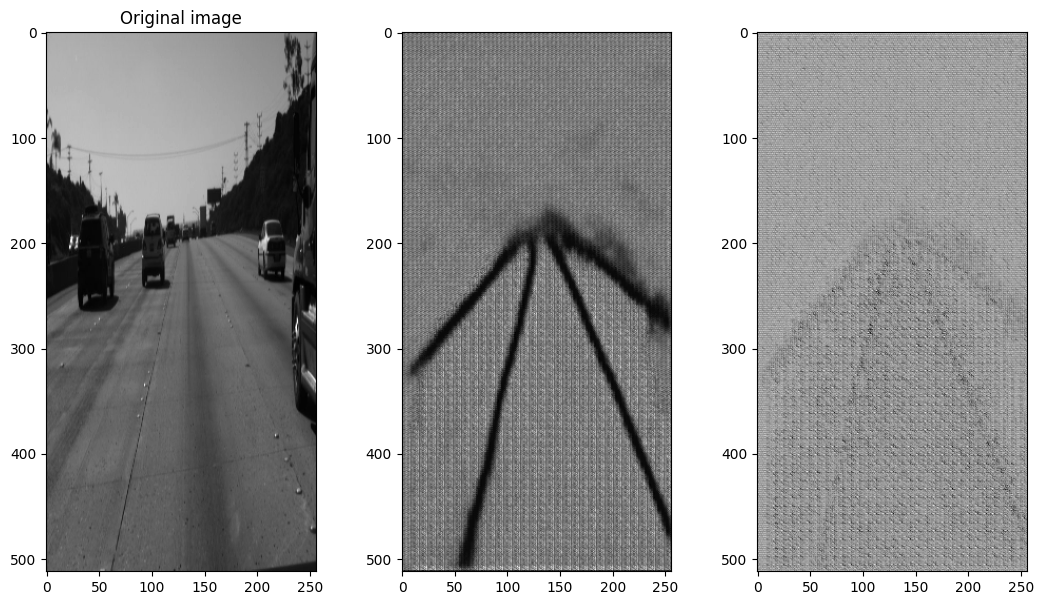

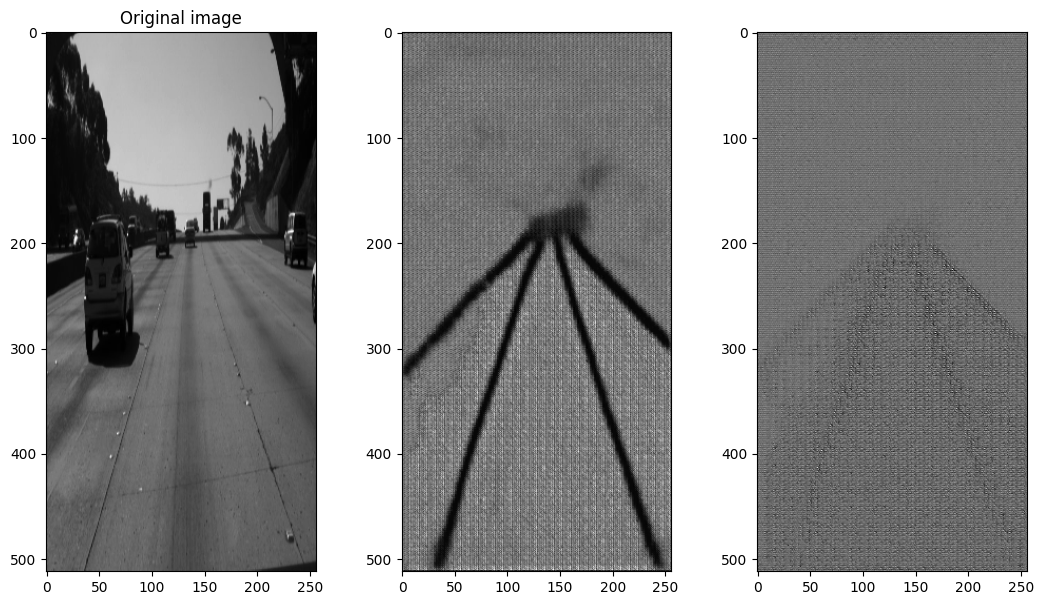

In [ ]:
import matplotlib.pyplot as plt

train_dataset = LaneDataset('data/tusimple/TUSimple/train_set', train='val', size=DEFAULT_SIZE)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=False)

images, _, _ = next(iter(train_loader))

with torch.no_grad():
  outputs = model_enet(images / 255)

for i in range(len(images)):
  img = images[i].squeeze().numpy()
  output = outputs[0][i].cpu().numpy().squeeze()

  plt.figure(figsize=(13, 7))
  plt.subplot(1, 3, 1)
  plt.imshow(img, cmap='gray')
  plt.title('Original image')

  plt.subplot(1, 3, 2)
  plt.imshow(output[0], cmap='gray')

  plt.subplot(1, 3, 3)
  output = outputs[1][i].cpu().numpy().squeeze()
  plt.imshow(output[0], cmap='gray')

  plt.show()

## Homograpy Prediction Code

Here we again need to implement the Dataset class. Dataset class should return resized image and ground truth points for the lane trajectories.


In [11]:
HNET_DEFAULT_SIZE = (64, 128)
import torch
from PIL import Image

class HomographyPredictionDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, train=True, size=DEFAULT_SIZE):
        self.dataset_path = dataset_path
        self.train = train
        self.size = size
        self.image_list = []
        self.lanes_list = []
        self.max_lanes = 0
        self.max_points = 0

        assert os.path.exists(self.dataset_path)

        label_files = []
        if self.train:
          label_files.append(os.path.join(self.dataset_path, 'label_data_0313.json'))
          label_files.append(os.path.join(self.dataset_path, 'label_data_0531.json'))
        else:
          label_files.append(os.path.join(self.dataset_path, 'label_data_0601.json'))


        for file in label_files:
          try:
            for line in open(file).readlines():
              info_dict = json.loads(line)
              self.image_list.append(info_dict['raw_file'])
              h_samples = info_dict['h_samples']
              lanes = info_dict['lanes']
              self.max_lanes = max(self.max_lanes, len(lanes))
              xy_list = []

              for lane in lanes:
                y = np.array([h_samples], dtype=np.float64).T
                x = np.array([lane], dtype=np.float64).T
                xy = np.hstack((x, y))
                index = np.where(xy[:, 0] > 2)
                xy_list.append(xy[index])
                self.max_points = max(self.max_points, len(xy[index]))
              self.lanes_list.append(xy_list)
          except BaseException:
            raise Exception('Fail to load {}'.format(file))

    def __getitem__(self, idx):
        img_path = os.path.join(self.dataset_path, self.image_list[idx])

        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        original_height, original_width, _ = image.shape
        image = cv2.resize(image, self.size, interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image[..., None]

        image = np.transpose(image, (2, 0, 1))
        image = torch.from_numpy(image).float() / 255

        buffer = None

        for lane in self.lanes_list[idx]:
          lane = np.expand_dims(np.pad(np.swapaxes(lane, 0, 1),
                                       pad_width=((0, 0), (0, self.max_points - lane.shape[0])),
                                       mode='constant',
                                       constant_values=0), 0)
          if buffer is not None:
            buffer = np.concatenate((buffer, lane), 0)
          else:
            buffer = lane

        buffer[:, 0, :] /= original_width
        buffer[:, 0, :] *= self.size[0]
        buffer[:, 1, :] /= original_height
        buffer[:, 1, :] *= self.size[1]

        ground_truth_trajectory = torch.from_numpy(np.pad(buffer,
                                                   pad_width=((0, self.max_lanes - buffer.shape[0]),
                                                              (0, 0),
                                                              (0, 0)),
                                                   mode='constant',
                                                   constant_values=0))

        return image, ground_truth_trajectory

    def __len__(self):
        return len(self.image_list)

In [12]:
HomographyPredictionDataset('data/tusimple/TUSimple/train_set')[0][1].shape

torch.Size([4, 2, 56])

In [13]:
dataset = HomographyPredictionDataset('data/tusimple/TUSimple/train_set')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [14]:
x,y = next(iter(dataloader))

Now we need to implement the H-Net. It should return homography matrix that is parametrized by 6 numbers.
Corresponding section is CURVE FITTING USING H-NET in the[ LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

We suggest to follow the paper and take 64x128 image as in input.

Homography projection contains discontinuities, therefore it could be quite difficult to train the network. In order to simplify the problem we propose not to train the homography from scratch, but train some correction to a good starting point.

The following code block contains the initial homography that you can use.


In [13]:
import torch

# important note: this homography matrix is suitable only for 64x128 resolution
R = torch.Tensor([[-2.0484e-01, -1.7122e+01,  3.7991e+02],
                  [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
                  [ 0.0000e+00, -4.6739e-02,  1.0000e+00]])

Let's check the effect of this homography on the image.

In [19]:
# !wget https://miro.medium.com/max/2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg

In [15]:
from matplotlib import pyplot as plt
import cv2

In [16]:
image = plt.imread('1*b3HiwPg69Rw0L5iIMQMXOw.jpeg')

In [17]:
image = cv2.resize(image, (128, 64))

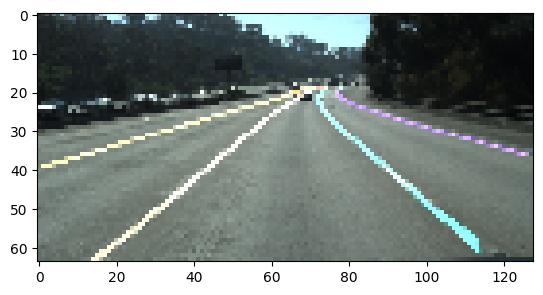

In [18]:
plt.imshow(image)

In [20]:
R_np = R.numpy()

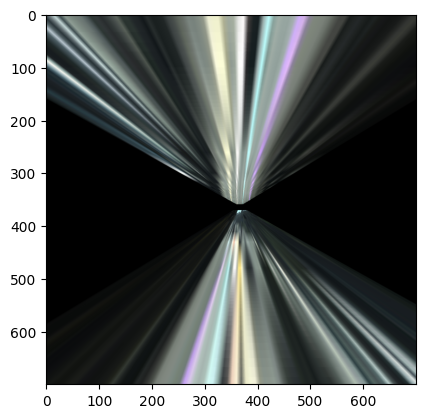

In [21]:
plt.imshow(cv2.warpPerspective(image, R_np, dsize=(700, 700)))

As you can see it looks like a bird's eye view projection where lines are becoming parallel.

In [18]:
class HNet(nn.Module):
    def __init__(self):
        super(HNet, self).__init__()
        self.conv1 = self.hnet_block(1, 16)
        self.conv2 = self.hnet_block(16, 16)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv3 = self.hnet_block(16, 32)
        self.conv4 = self.hnet_block(32, 32)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.conv5 = self.hnet_block(32, 64)
        self.conv6 = self.hnet_block(64, 64)
        self.maxpool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64*16*8, out_features=1024),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.fc2 = nn.Linear(in_features=1024, out_features=6)

    def hnet_block(self, in_channels, out_channels):
      return nn.Sequential(
          nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(out_channels),
          nn.ReLU()
      )

    def forward(self, x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.maxpool1(x)
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.maxpool2(x)
      x = self.conv5(x)
      x = self.conv6(x)
      x = self.maxpool3(x)
      print('----------------------')
      print(x.shape)
      print(x.size())
      print(x.size(0))
      x = x.view(x.size(0), -1)
      print('2')
      print(x.shape)
      x = self.fc1(x)
      x = self.fc2(x)

      return x

In [29]:
HNet()(torch.ones(2, 1, 128, 64))

tensor([[ 0.0282, -0.0297, -0.0122,  0.0043, -0.0028,  0.0237],
        [ 0.0282, -0.0297, -0.0122,  0.0043, -0.0028,  0.0237]],
       grad_fn=<AddmmBackward0>)

Finally, we need to implement the loss to fit the network. This is the most difficult part of the project. Homography loss should do the following:

1. Project ground truth trajectory to the new plane according to the homography to obtain $(x', y')$.
2. Perform polynomial fitting $x' = f(y')$. Your code should work correctly with 2-nd and 3-rd order polynomials. Polynomial fitting should be done with the closed-form solution: $w = (Y^TY)^{-1}Y^Tx$ to be able to pass a gradient through.
3. Compute back projection with the inverse homography.
4. Compute loss between back projected $\hat{x}$ and ground truth $x$.

The full description can be found in the [LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

**IMPORTANT NOTES**

* To fit the polynomial you need to compute the inverse matrix. Computation of the inverse is computation unstable operation. With the help of the SVD you can compute pseudo-inverse matrix: $(X^TX)^{-1}X^T$. In torch this function is called `torch.pinverse`.
* After projection use of the raw $y'$ can be impractical. The features for the polynomial fitting could have a high correlation and therefore solution can be unstable. At first, you need to map $y'$ to some fixed size segment and only then perform a fit.
* After projection some points can occur on the other side of image (bottom part of the projection in the example above). You may want to exclude them, because otherwise polynomial is not going to have much sense and gradients can have a dramatically large values. Positive $w$ in homogeneous coordinates indicates that point is on the wrong side.
* If use the homography provided above, your ground truth should have the same scale, as an image
* Every division in your network is a potential place to obtain `nan` in gradients. Use the following trick to obtain less divisions:
after computing the projection, remember the $w$. Then, before the back projection, multiply your vector by $w$. After back projection you will see that $w$ is equal to 1. So you don't need to devide your vector by $w$.
* You correction to the initial homography could be very big and can completely spoil the homography. So you may need to scale the output of the last layer in the HNet to obtain a smaller corrections.


In [8]:
class HomographyLoss(torch.nn.modules.loss._Loss):
    # def __init__(self, reduction='mean', device='cuda'):
    def __init__(self, reduction='mean', device='cpu'):
        super(HomographyLoss, self).__init__(reduction=reduction)
        self.device = device
        self.ref_homography = torch.tensor(
            [[-2.0484e-01, -1.7122e+01,  3.7991e+02],
             [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
             [ 0.0000e+00, -4.6739e-02,  1.0000e+00]],
            dtype=torch.float32, device=device)


    def forward(self, predicted_corrections, traget_lanes):
        assert predicted_corrections.shape[0] == traget_lanes.shape[0]
        losses = []

        for correction, gt_lane in zip(predicted_corrections, traget_lanes):
          for lane in gt_lane:
            if lane.sum() == 0:
              continue
            lane_loss = self.compute_loss_for_labe(correction, lane)
            if lane_loss is not None:
              losses.append(lane_loss)

        return torch.stack(losses).mean() if losses else torch.tensor(0.0, device=self.device)

    def compute_loss_for_labe(self, correction, lane):
      H_correction_indices = [0, 1, 2, 4, 5, 7]
      H_correction = correction.flatten()
      H = self.ref_homography.flatten().clone()
      H[H_correction_indices] = H_correction
      H = H.reshape((3, 3))

      points = lane.T
      index = points.nonzero().flatten().max().item() + 1
      points = points[:index, :]
      ones_col = torch.ones(points.shape[0], device=self.device)
      P = torch.column_stack((points, ones_col)).T.to(torch.float32)
      P_transformed = H @ P

      x_transformed = P_transformed[0, :].T
      y_transformed_squares = P_transformed[1, :] ** 2
      y_transformed = P_transformed[1, :].T
      Y = torch.column_stack((y_transformed_squares, y_transformed, ones_col))
      w = torch.pinverse(Y.T @ Y) @ Y.T @ x_transformed

      x_predicted = Y @ w
      P_predicted = torch.column_stak((x_predicted, y_transformed, ones_col)).T
      P_reprojected = torch.linalg.inv(H.detach()) @ P_predicted
      P_reprojected = torch.div(P_reprojected, P_reprojected[2, :])

      loss = ((points[:, 0].T - P_reprojected[0, :]) ** 2).mean()

      return loss

Finally, train the homography net with the 2-nd order polynomial fitting (you can 3-rd order but we found out that it is much easier to train h-net with the 2-nd order polynomials).

We found out that SGD fits much better for this architectures. Adam (and momentums inside) can ruin the weights because of the discontinuities in the target function surface.

Demonstrate the difference in homography loss between h-net and provided fixed homography on the validation samples.

In [9]:
# 32:55

class HomographyModel(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.model = HNet()
    self.loss = HomographyLoss()

  def forward(self, x):
    return self.model(x)

  def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x/255)
    loss = self.loss(y_hat, y)
    self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
    return loss

  def configure_optimizers(self):
    return torch.optim.SGD(self.model.parameters(), lr=1e-5)

  def train_dataloader(self):
    dataset = HomographyPredictionDataset('data/tusimple/TUSimple/train_set/')
    return DataLoader(dataset, batch_size=64, shuffle=True)


In [ ]:
# device = torch.device('cuda')
device = torch.device('cpu')
early_stopping = EarlyStopping(monitor='train_loss', patience=20)

model_hnet = HomographyModel()
trainer = pl.Trainer(max_epochs=32, gradient_clip_val=0.5, devices=1, callbacks=[early_stopping])

trainer.fit(model_hnet)



INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type           | Params | Mode 
-------------------------------------------------
0 | model | HNet           | 8.5 M  | train
1 | loss  | HomographyLoss | 0      | train
-------------------------------------------------
8.5 M     Trainable params
0         Non-trainable params
8.5 M     Total params
33.873    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]